**PART A : PCA**


## Import required libraries

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

## Load MNIST dataset using TensorFlow

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Normalize pixel values and reshape


In [ ]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0


train_data = x_train.reshape((-1, 28*28))
test_data = x_test.reshape((-1, 28*28))

## Reconstrution function

In [ ]:
def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    return mse

In [ ]:
pca_mse_values = []

new_images = []
latent_dims = [2, 4, 8, 16, 32, 64]

for latent_dim in latent_dims:

    pca = PCA(n_components=latent_dim)           # Applying PCA
    pca.fit(train_data)
    transformed_data = pca.transform(test_data)
    reconstructed_image = pca.inverse_transform(transformed_data)


    mse = mean_squared_error(test_data.flatten(), reconstructed_image.flatten())
    pca_mse_values.append(mse)

    new_images.append(reconstructed_image)

## PLOT

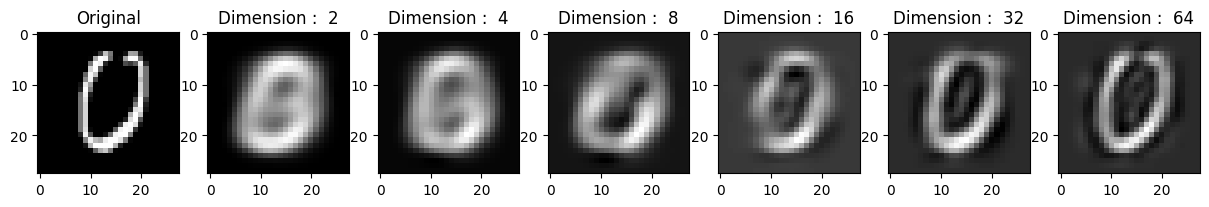

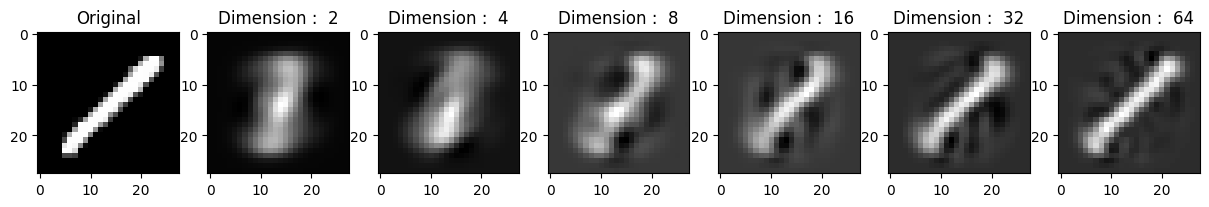

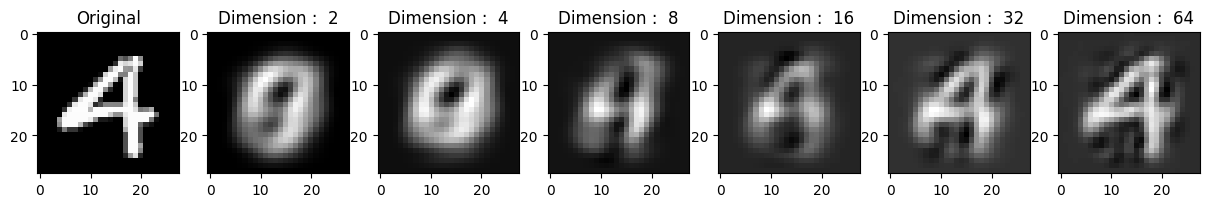

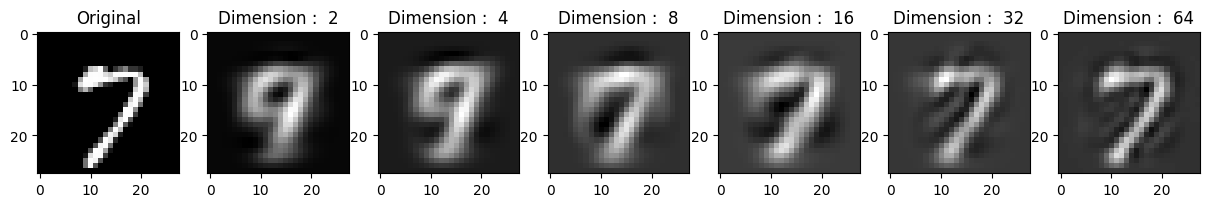

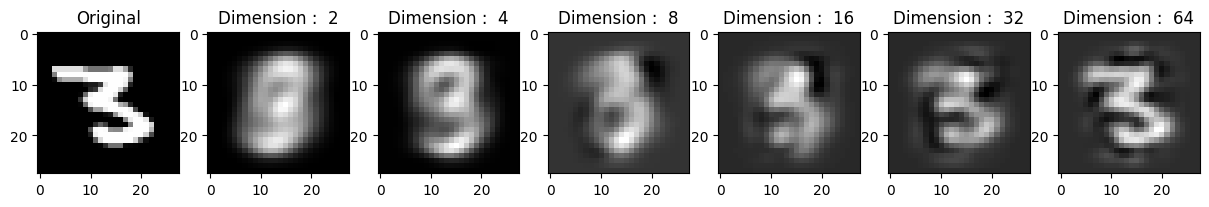

In [ ]:
for i in range(5):
    random_value = np.random.randint(0, 10000)
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 7, 1)
    plt.imshow(test_data[random_value].reshape(28, 28) * 255, cmap='gray')
    plt.title('Original')

    for j, latent_dim in enumerate(latent_dims):
        plt.subplot(1, 7, j+2)
        plt.imshow(new_images[j][random_value].reshape(28, 28) * 255, cmap='gray')
        plt.title(f'Dimension :  {latent_dim}')

    plt.show()

## Error :

In [ ]:
for i in range(len(latent_dims)):
    print(f'Latent dimension : {latent_dims[i]}, mean squared error : {pca_mse_values[i]}')

Latent dimension : 2, mean squared error : 0.05566943436861038
Latent dimension : 4, mean squared error : 0.04790343716740608
Latent dimension : 8, mean squared error : 0.03744112327694893
Latent dimension : 16, mean squared error : 0.026860399171710014
Latent dimension : 32, mean squared error : 0.016827845945954323
Latent dimension : 64, mean squared error : 0.009047229774296284


**Part B : Probabilistic PCA**

## Importing data

In [ ]:

import random


mnist = tf.keras.datasets.mnist
(train_images, _), (test_images, _) = mnist.load_data()
np.random.seed(42)
random.seed(42)
latent_dims = [2, 4, 8, 16, 32, 64]
num_images_to_display = 5
random_indices = random.sample(range(len(test_images)), num_images_to_display)

In [ ]:
# Standardize the data

# Flatten the images
train_images_flat = train_images.reshape(-1, 28*28)
test_images_flat = test_images.reshape(-1, 28*28)
train_images_flat_std = (train_images_flat - np.mean(train_images_flat)) / np.std(train_images_flat)
test_images_flat_std = (test_images_flat - np.mean(train_images_flat)) / np.std(train_images_flat)

In [ ]:
def sample_latent(latent_dim,num_samples):
    mu = np.zeros(latent_dim)
    cov_matrix = np.eye(latent_dim)
    latent_samples = np.random.multivariate_normal(mu, cov_matrix, size=num_samples)
    return latent_samples

In [ ]:
class PPCA:
    def __init__(self, latent_dim, max_iter=100, tol=1e-6):
        self.latent_dim = latent_dim
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        N, D = X.shape
        self.mu = np.mean(X, axis=0)
        self.W = np.random.randn(D, self.latent_dim)
        self.sigma2 = 1.0

        for iter in range(self.max_iter):
            M = np.linalg.inv(np.eye(self.latent_dim) + self.W.T @ self.W / self.sigma2)
            Z = (X - self.mu) @ self.W @ M / self.sigma2

            self.W = (X - self.mu).T @ Z @ np.linalg.inv(Z.T @ Z + N * self.sigma2 * M)
            residuals = X - self.mu - Z @ self.W.T
            self.sigma2 = np.mean(np.sum(residuals ** 2, axis=1)) / D

            if iter > 0 and np.abs(prev_sigma2 - self.sigma2) < self.tol:
                break

            prev_sigma2 = self.sigma2

        return self


    def sample_latent(self, X):
        N = X.shape[0]
        M = np.linalg.inv(np.eye(self.latent_dim) + self.W.T @ self.W / self.sigma2)
        Z = (X - self.mu) @ self.W @ M / self.sigma2
        return Z

    def reconstruct(self, Z):
        return Z @ self.W.T + self.mu

In [ ]:

ppca_models = []
for latent_dim in tqdm(latent_dims, desc="Fitting PPCA models"):
    ppca = PPCA(latent_dim=latent_dim)
    ppca.fit(train_images_flat_std)
    ppca_models.append(ppca)

Fitting PPCA models: 100%|██████████| 6/6 [05:39<00:00, 56.62s/it]


In [ ]:
reconstructed_images_ppca = []
for ppca in tqdm(ppca_models, desc="Reconstructing test images"):
    Z_test = ppca.sample_latent(test_images_flat_std)
    reconstructed_image = ppca.reconstruct(Z_test)
    reconstructed_images_ppca.append(reconstructed_image)

Reconstructing test images: 100%|██████████| 6/6 [00:00<00:00,  8.96it/s]


## Plot

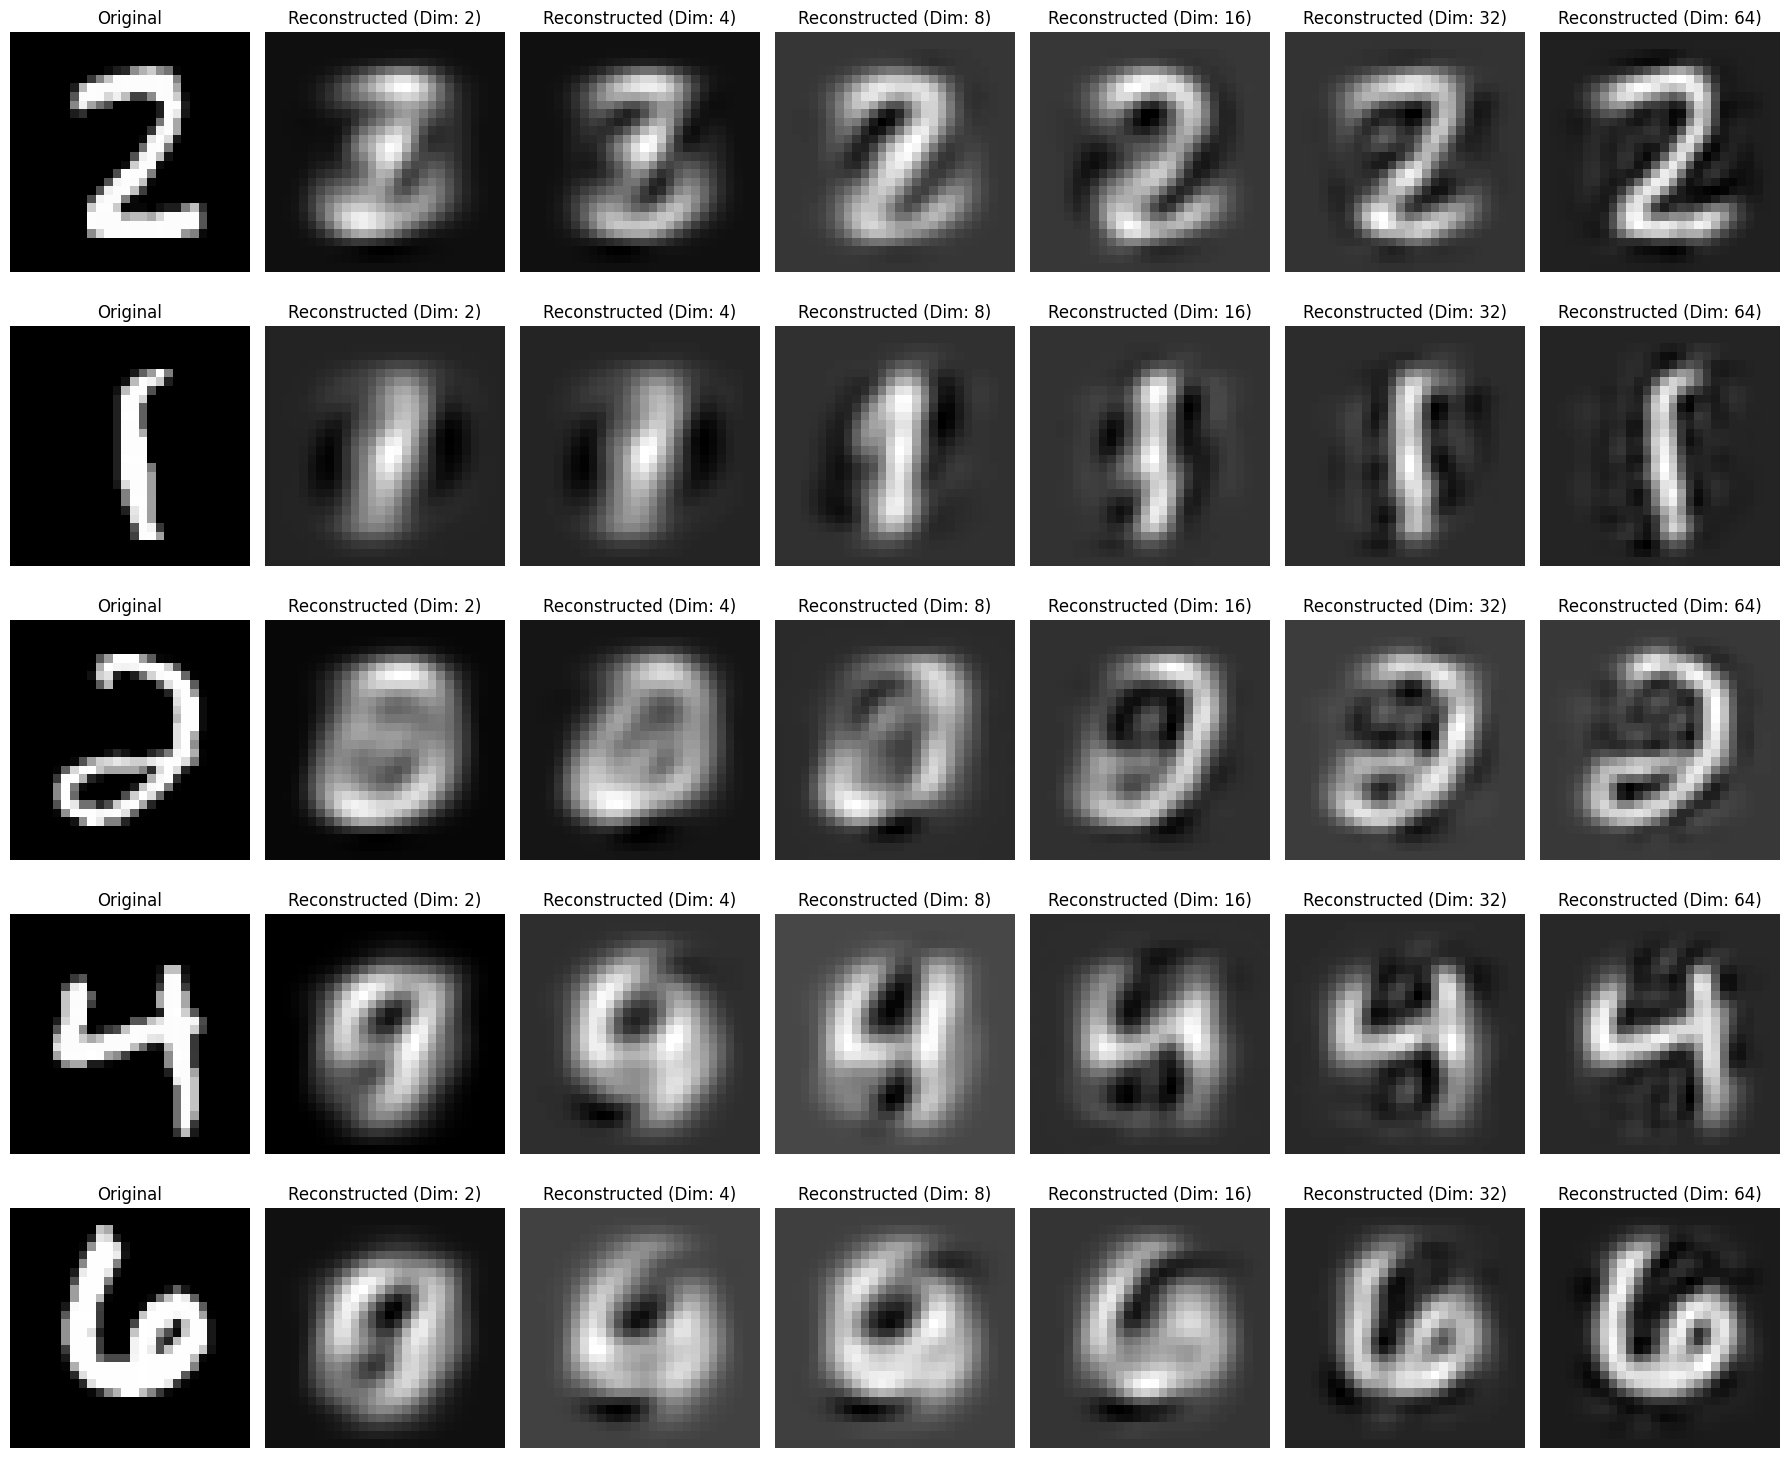

In [ ]:
num_samples = 5
num_models = len(latent_dims)

fig, axes = plt.subplots(num_samples, num_models + 1, figsize=(num_models * 3, num_samples * 3))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(test_images[idx].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    for j in range(num_models):
        axes[i, j + 1].imshow(reconstructed_images_ppca[j][idx].reshape(28, 28), cmap='gray')
        axes[i, j + 1].set_title(f'Reconstructed (Dim: {latent_dims[j]})')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
mse_scores_ppca = {}
for latent_dim, reconstructed_image in zip(latent_dims, reconstructed_images_ppca):
    reconstructed_data = reconstructed_image.reshape(-1, 28*28)
    mse = np.mean((test_images_flat_std - reconstructed_data)**2)
    mse_scores_ppca[latent_dim] = mse

for latent_dim, mse in mse_scores_ppca.items():
    print(f"Latent Dimension: {latent_dim}, MSE: {mse}")



Latent Dimension: 2, MSE: 0.5864296895937319
Latent Dimension: 4, MSE: 0.5045968802688311
Latent Dimension: 8, MSE: 0.39431396558727255
Latent Dimension: 16, MSE: 0.2829586660912335
Latent Dimension: 32, MSE: 0.1772455199492758
Latent Dimension: 64, MSE: 0.09532262452035184


**Part C : Variational Autoencoder**

## Importing required libraries and importing dataset

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model



# Load dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))      # creating channel for CNN
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

## Defining autoencoder model

In [ ]:
def build_vae(latent_dim):
    # Encoder
    encoder_inputs = Input(shape=(28, 28, 1))
    x = Conv2D(2, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = Conv2D(2, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_inputs = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(2, 3, activation='relu', strides=2, padding='same')(x)

    x = Conv2DTranspose(2, 3, activation='relu', strides=2, padding='same')(x)

    decoder_outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)


    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')              # Defining models
    decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, vae_outputs, name='vae')





    return vae                                                                          # returning model


def calculate_mse(y_true, y_pred):                                                    # Function to calculate Mean Squared Error
    mse = np.mean(np.square(y_true - y_pred))
    return mse

##  Build VAE models, reconstruct images, and calculate MSE

In [ ]:
latent_dims = [2,4,8,16,32,64]


mse_values = []
reconstructed_images = []
for latent_dim in latent_dims:
    vae = build_vae(latent_dim)
    vae.compile(optimizer='adam', loss='mse')
    vae.fit(x_train, x_train, epochs=10,validation_data=(x_test, x_test))


    reconstructed = vae.predict(x_test)
    reconstructed_images.append(reconstructed)


    mse = calculate_mse(x_test, reconstructed)
    mse_values.append(mse)
    print(f"Latent Dimension {latent_dim}: MSE = {mse}")

vae_mse_values = mse_values

Epoch 1/10
1875/1875 [==============================] - 29s 14ms/step - loss: 0.0649 - val_loss: 0.0549
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0527 - val_loss: 0.0512
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0505 - val_loss: 0.0498
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0497 - val_loss: 0.0493
Epoch 5/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0492 - val_loss: 0.0489
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0490 - val_loss: 0.0487
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0488 - val_loss: 0.0485
Epoch 8/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0486 - val_loss: 0.0483
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0484 - val_loss: 0.0483
Epoch 10/10
313/313 [==============================] - 2s 6ms/st

## Error





In [ ]:
for i, latent_dim in enumerate(latent_dims):
    print(f"Latent variable dimension {latent_dim}:")
    print(f"Mean Squared Error: {mse_values[i]}")

Latent variable dimension 2:
Mean Squared Error: 0.04791558161377907
Latent variable dimension 4:
Mean Squared Error: 0.03476497903466225
Latent variable dimension 8:
Mean Squared Error: 0.021271342411637306
Latent variable dimension 16:
Mean Squared Error: 0.011189330369234085
Latent variable dimension 32:
Mean Squared Error: 0.005509002134203911
Latent variable dimension 64:
Mean Squared Error: 0.00406809663400054


## 5 random images

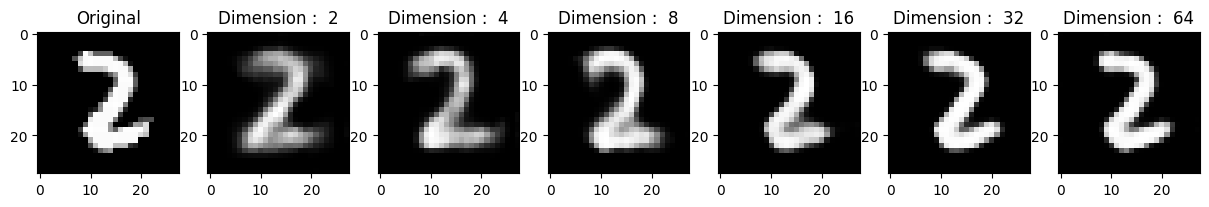

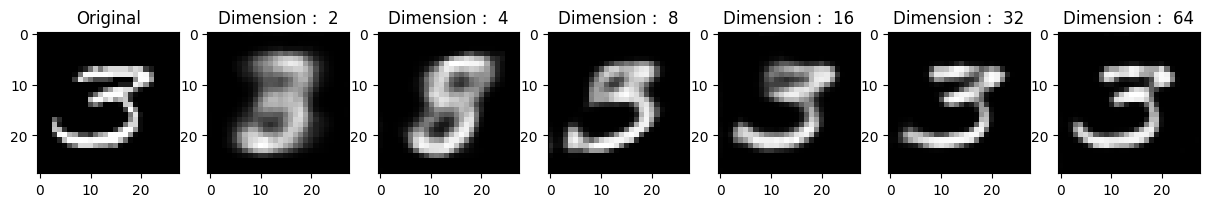

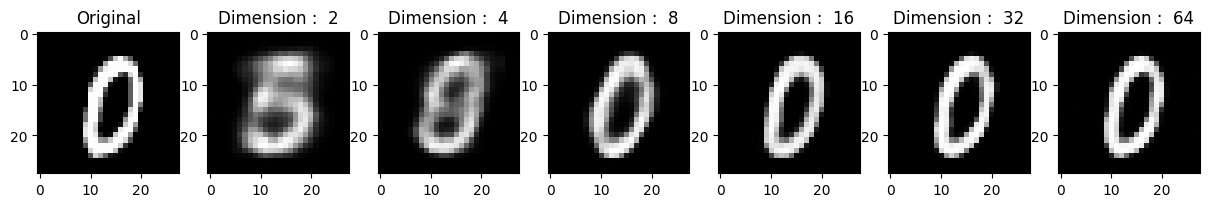

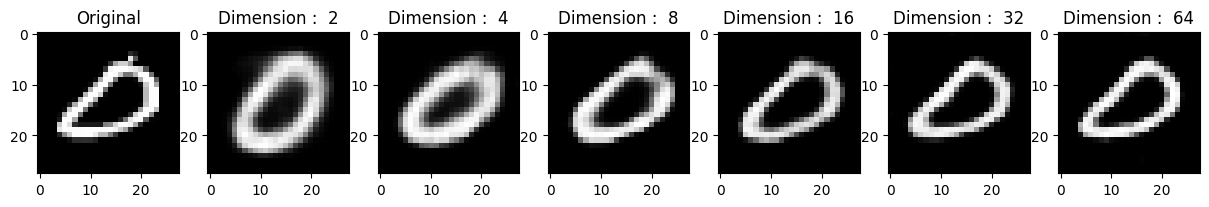

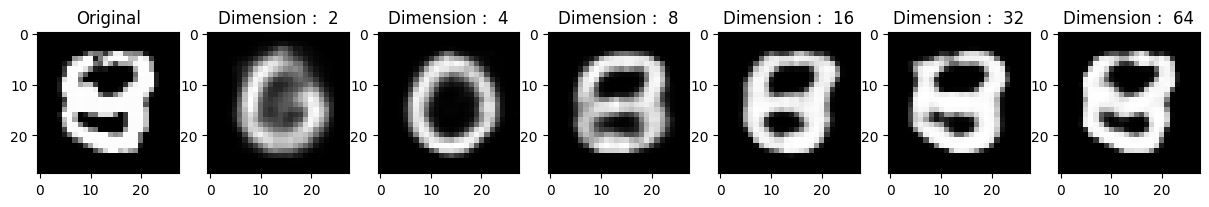

In [ ]:
for i in range(5):
    random_value = np.random.randint(0, 10000)
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 7, 1)
    plt.imshow(x_test[random_value].reshape(28, 28) * 255, cmap='gray')
    plt.title('Original')

    for j, latent_dim in enumerate(latent_dims):
        plt.subplot(1, 7, j+2)
        plt.imshow(reconstructed_images[j][random_value].reshape(28, 28) * 255, cmap='gray')
        plt.title(f'Dimension :  {latent_dim}')

    plt.show()


**MSE vs Latent Variable Dimension**

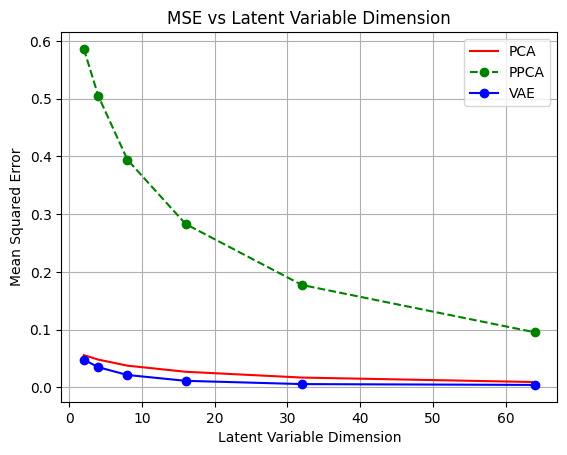

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the following variables:
# latent_dims, pca_mse_values, PPCA_mse_values, vae_mse_values

plt.plot(latent_dims, pca_mse_values, color='red', label='PCA')
plt.plot(latent_dims, list(mse_scores_ppca.values()), label='PPCA', marker='o', color='green', linestyle='--')
plt.plot(latent_dims, vae_mse_values, color='blue', label='VAE', marker='o')

plt.title('MSE vs Latent Variable Dimension')
plt.xlabel('Latent Variable Dimension')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()


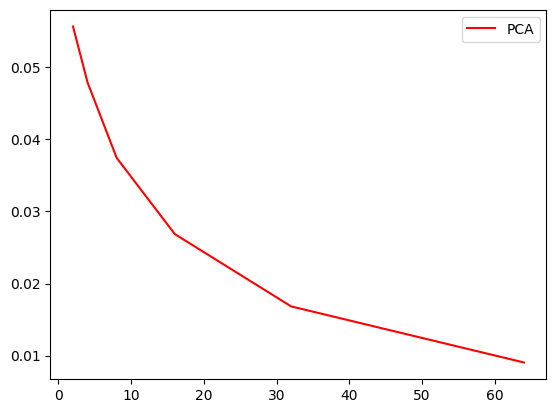

In [ ]:
plt.plot(latent_dims, pca_mse_values, color='red', label='PCA')
plt.legend()